# Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from ema_workbench import (
    ema_logging,
    perform_experiments,
    Scenario,
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
    Policy,
    MultiprocessingEvaluator,
    load_results, save_results
)


from ema_workbench.em_framework.optimization import (ArchiveLogger, EpsilonProgress, to_problem)
from ema_workbench.analysis import parcoords
from problem_formulation import get_model_for_problem_formulation
from MORDM_pyfile import MORDM_function


# Define calculation metrics

In [2]:
def calculate_metrics(archives, reference_set):
    problem = to_problem(dike_model, searchover="levers", reference=bestcase_scenario)

    hv = HypervolumeMetric(reference_set, problem)
    gd = GenerationalDistanceMetric(reference_set, problem, d=1)
    ei = EpsilonIndicatorMetric(reference_set, problem)
    ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
    sm = SpacingMetric(problem)

    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "generational_distance": gd.calculate(archive),
            "hypervolume": hv.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    return metrics


def plot_metrics(metrics, convergence):
    sns.set_style("white")
    fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)

    ax1, ax2, ax3, ax4, ax5, ax6 = axes

    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")

    ax3.plot(metrics.nfe, metrics.generational_distance)
    ax3.set_ylabel("generational distance")

    ax4.plot(metrics.nfe, metrics.epsilon_indicator)
    ax4.set_ylabel("epsilon indicator")

    ax5.plot(metrics.nfe, metrics.inverted_gd)
    ax5.set_ylabel("inverted generational\ndistance")

    ax6.plot(metrics.nfe, metrics.spacing)
    ax6.set_ylabel("spacing")

    ax6.set_xlabel("nfe")

    sns.despine(fig)

# Define model and best case scenario

In [3]:
ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation number, between 0-5
# each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(2)

# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

bestcase_scenario = Scenario('Best Case Scenario', **dict({
    'discount rate 0': 4.5,
    'discount rate 1': 4.5,
    'discount rate 2': 4.5,
    'A.0_ID flood wave shape': 4,
    'A.1_Bmax': 175,
    'A.2_Bmax': 175,
    'A.3_Bmax': 175,
    'A.4_Bmax': 175,
    'A.5_Bmax': 175,
    'A.1_pfail': 0,
    'A.2_pfail': 0,
    'A.3_pfail': 0,
    'A.4_pfail': 0,
    'A.5_pfail': 0,
    'A.1_Brate': 1.5,
    'A.2_Brate': 1.5,
    'A.3_Brate': 1.5,
    'A.4_Brate': 1.5,
    'A.5_Brate': 1.5
}))

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

# Define convergence metrics and optimization function for best case scenario

In [4]:
convergence_metrics = [ArchiveLogger(
                        "./archives",
                        [l.name for l in dike_model.levers],
                        [o.name for o in dike_model.outcomes],
                        base_filename="optimization_bestcase_10000x0001.tar.gz",
                        ),
                        EpsilonProgress(),
                        ]

In [5]:
nfe = 10000
epsilons = 0.001

results, convergence = MORDM_function(dike_model, bestcase_scenario, nfe, epsilons, convergence_metrics)

[MainProcess/INFO] pool started with 16 workers
10035it [11:43, 14.27it/s]                                                     
[MainProcess/INFO] optimization completed, found 55 solutions
[MainProcess/INFO] terminating pool


# Calculate metrics to check convergence

In [6]:
archives = ArchiveLogger.load_archives(f"./archives/optimization_bestcase_10000x05.tar.gz")
for key in archives:
    if 'Unnamed: 0' in archives[key].columns:
        archives[key] = archives[key].drop(columns=['Unnamed: 0'])
reference_set = archives[max(archives.keys())] # this is the final archive

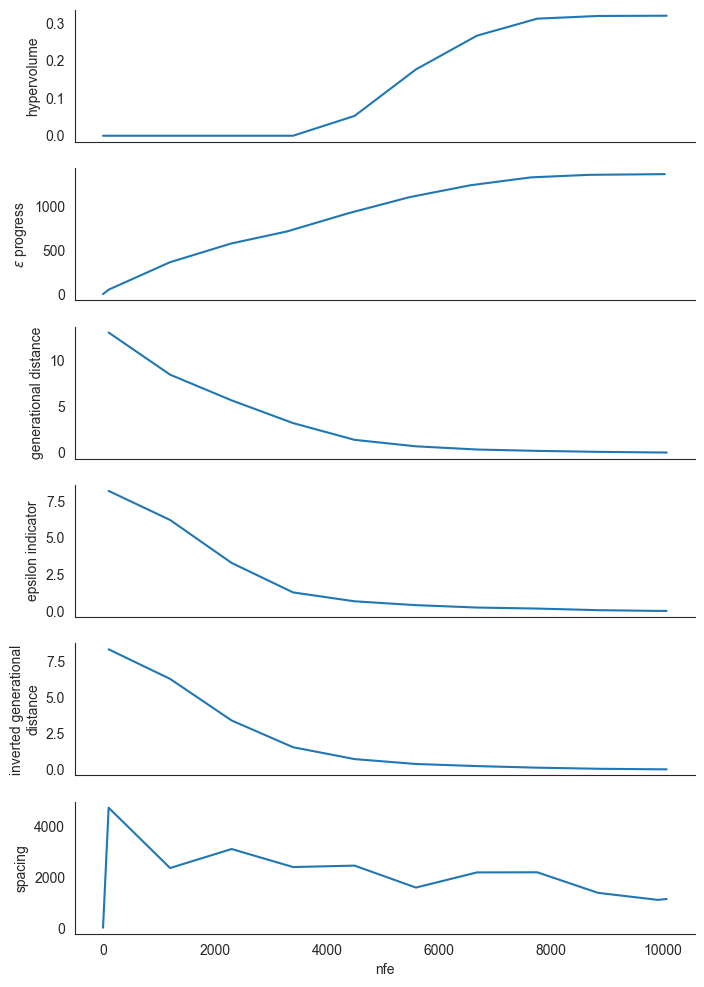

In [7]:
metrics = calculate_metrics(archives, reference_set)
plot_metrics(metrics, convergence)

plt.show()

# Visualise outcomes

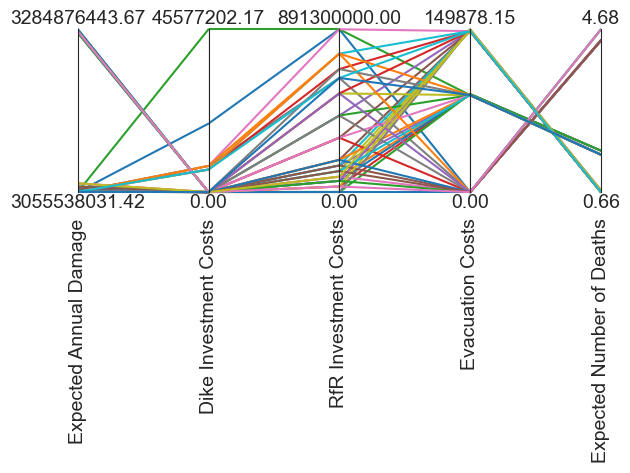

In [8]:
outcomes = reference_set.loc[:, ['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths']]

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
# axes.invert_axis('Expected Number of Deaths') 
# plt.show()


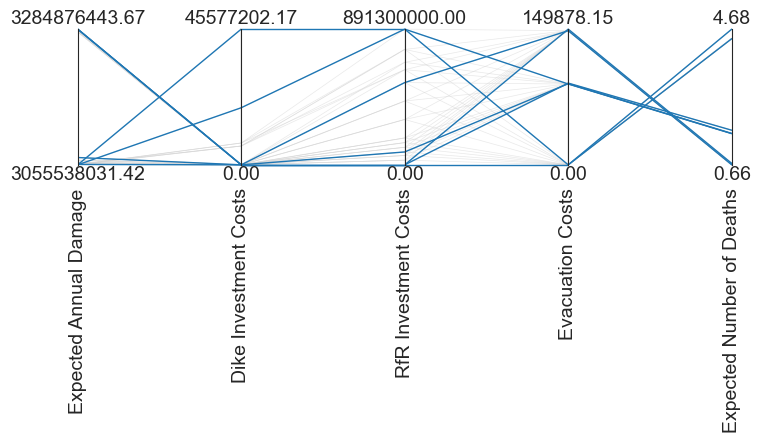

In [9]:
# conditional on y
all_data = pd.DataFrame({k:v for k,v in outcomes.items()})

# let's get the unique indices for the minima and maxima across 
# all objectives
indices = pd.concat([all_data.idxmax(), all_data.idxmin()]).unique()

limits = parcoords.get_limits(all_data)
axes = parcoords.ParallelAxes(limits)

# we set the linewidth lower, and make the lines slightly transparent using alpha
# this often helps reveal patterns in the results.
axes.plot(all_data, color='lightgrey', lw=0.5, alpha=0.5)
axes.plot(all_data.iloc[indices, :], color=sns.color_palette()[0], lw=1)

fig = plt.gcf()
fig.set_size_inches((8, 4))

plt.show()

# Robustness test

In [10]:
candidate_solutions = reference_set.iloc[indices]
candidate_solutions = candidate_solutions.drop([o.name for o in dike_model.outcomes], axis=1)

candidate_policies = []

for i, policy in candidate_solutions.iterrows():
    candidate_policies.append(Policy(str(i), **policy.to_dict()))

In [11]:
n_scenarios = 10000
with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments, results = evaluator.perform_experiments(n_scenarios,
                                            candidate_policies)
    
save_results('robustness_reference_10000.tar.gz')

[MainProcess/INFO] pool started with 16 workers
[MainProcess/INFO] performing 10000 scenarios * 7 policies * 1 model(s) = 70000 experiments
100%|██████████████████████████████████| 70000/70000 [1:06:36<00:00, 17.52it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


TypeError: save_results() missing 1 required positional argument: 'file_name'

In [ ]:
load_results('robustness_reference_10000.tar.gz')

In [ ]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [ ]:
experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

In [ ]:
data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis('max_P')
plt.show()

In [ ]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()
    
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()